# Examine raw fingerprints

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = {}
with open('../../combind_data/bpp_outputs/fps.csv') as fp:
    fp.readline()
    for line in fp:
        try:
            (protein, struct, ligand, rank, gscore, emodel,
             rmsd, finger) = line.strip().split('\t')
            if protein not in data: data[protein] = {}
            if ligand not in data[protein]: data[protein][ligand] = {}
            finger = {(int(interaction), residue): float(score)
                      for interaction, residue, score in \
                      map(lambda x: x.split(','), finger.split(';'))}
            gscore, emodel, rmsd = float(gscore), float(emodel), float(rmsd)
            rank = int(rank)
            data[protein][ligand][rank] = (gscore, emodel, rmsd, finger)
        except:
            pass

In [3]:
for protein, ligand in data.items():
    print protein, len(ligand)

P00489 20
5HT2B 2
PLK1 12
Q16539 19
MGLUR5 5
ERA 19
M3 2
P07900 20
GLUT1 3
P18031 20
P56817 20
O60885 17
MEK1 20
JAK2 20
P00742 20
DTRANSP 9
SIGMA1 2
P00734 20
P00760 20
B2AR 8
GCR 18
P24941 13
B1AR 12
VITD 20
A2AR 18
SMO 7
P03951 14
P00749 20
Q9Y233 20
CHK1 20
TRPV1 2
CDK2 20
AR 11
BRAF 19
MR 13
STRANSP 5


In [4]:
features = {
    'hbond_donor':[2],
    'hbond_acceptor':[3],
    #'sb1':[0],
    'sb2':[1],
    #'sb3':[4],
    'pipi':[6],
    'picat':[7,8],
    'contact':[11]
}

# Number of each interaction type

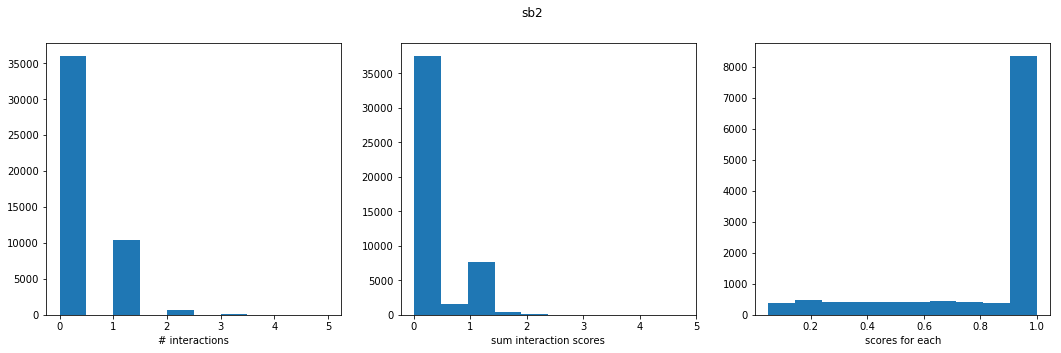

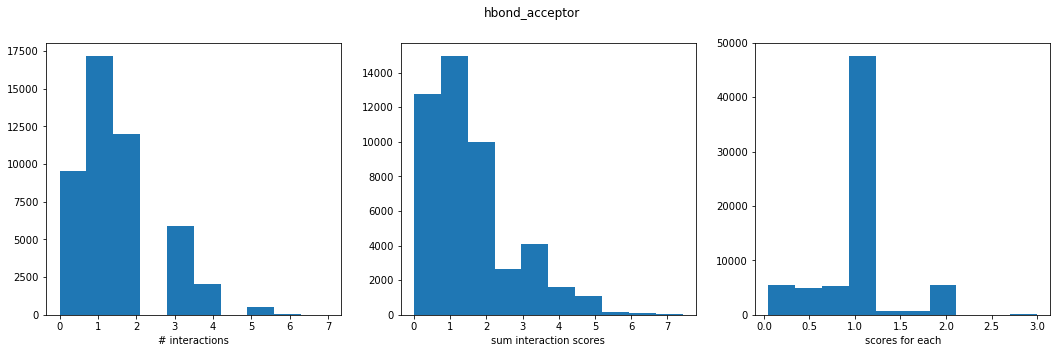

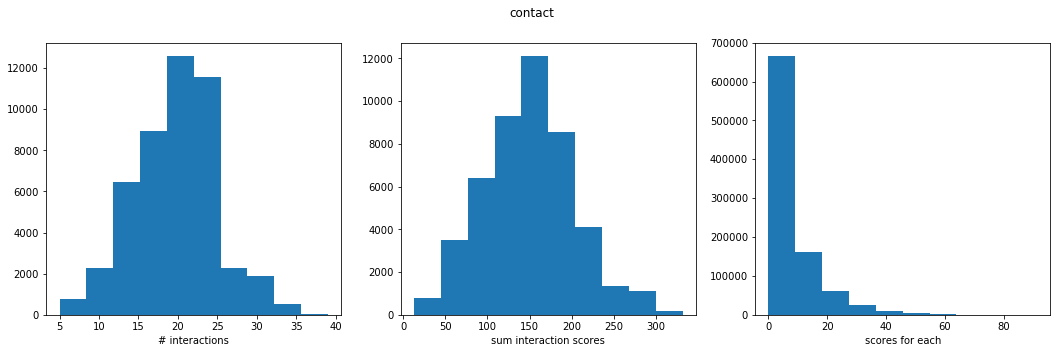

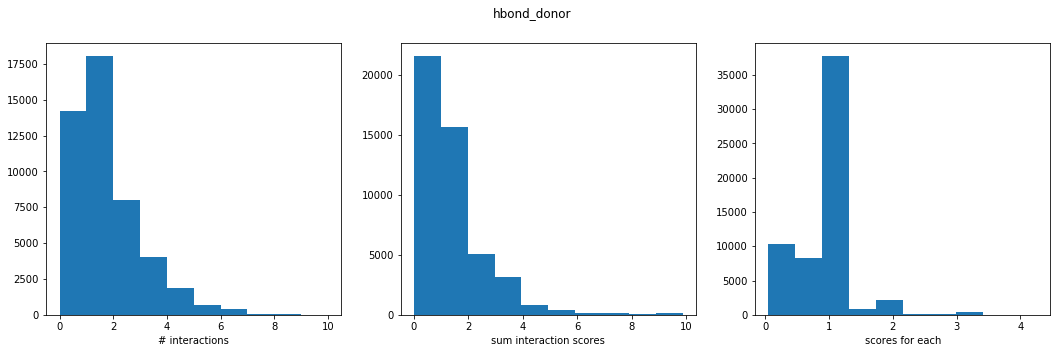

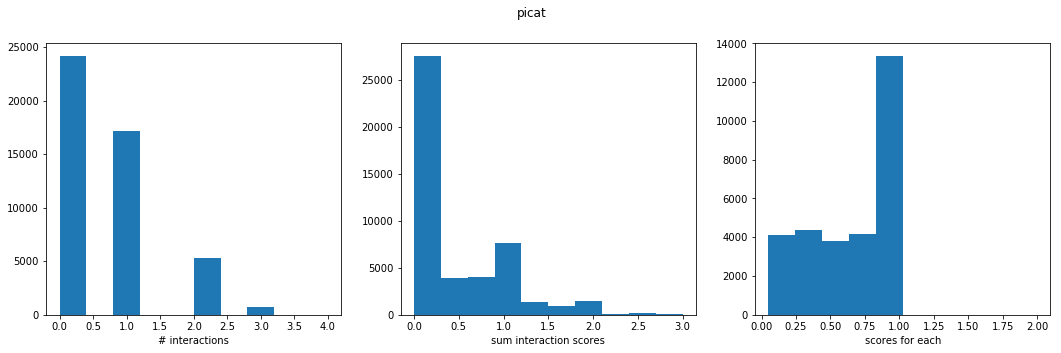

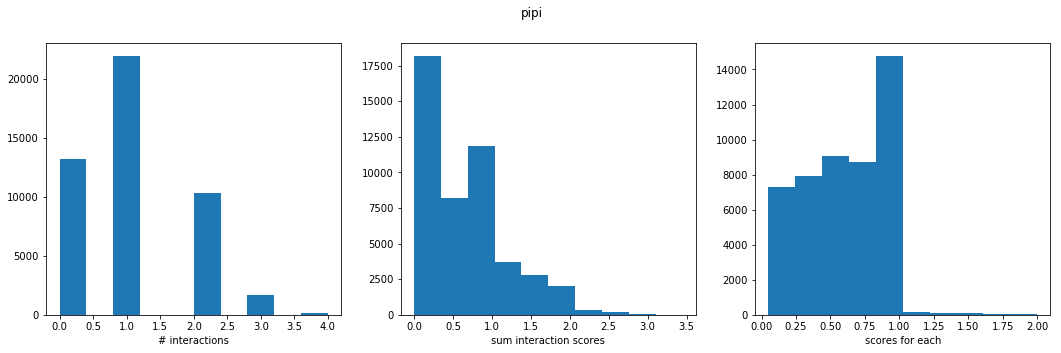

In [32]:
for feature, codes in features.items():
    scoress = []
    f, ax = plt.subplots(1, 3, figsize = (18, 5))
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                scoress += [[score
                            for (code, residue), score in pose[-1].items()
                            if code in codes]]
    ax[0].hist([len(scores) for scores in scoress])
    ax[1].hist([sum(scores) for scores in scoress])
    ax[2].hist([score for scores in scoress for score in scores])
    ax[0].set_xlabel('# interactions')
    ax[1].set_xlabel('sum interaction scores')
    ax[2].set_xlabel('scores for each')
    plt.suptitle(feature)
    plt.show()

0.525059147112
0.526943967776


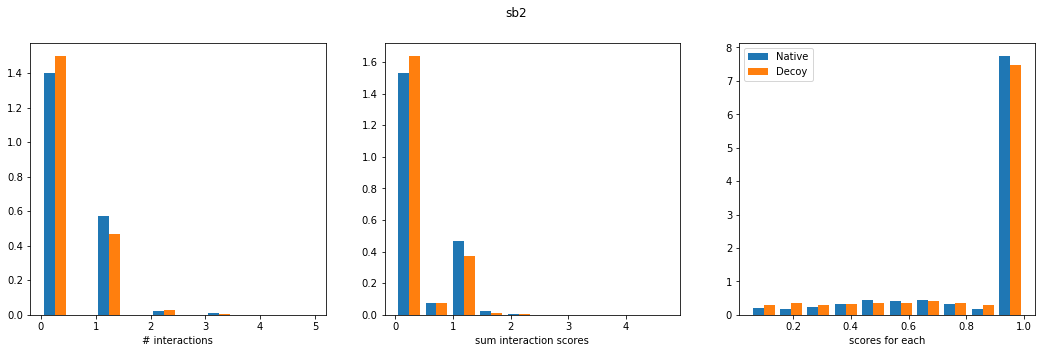

0.592932123298
0.608363787103


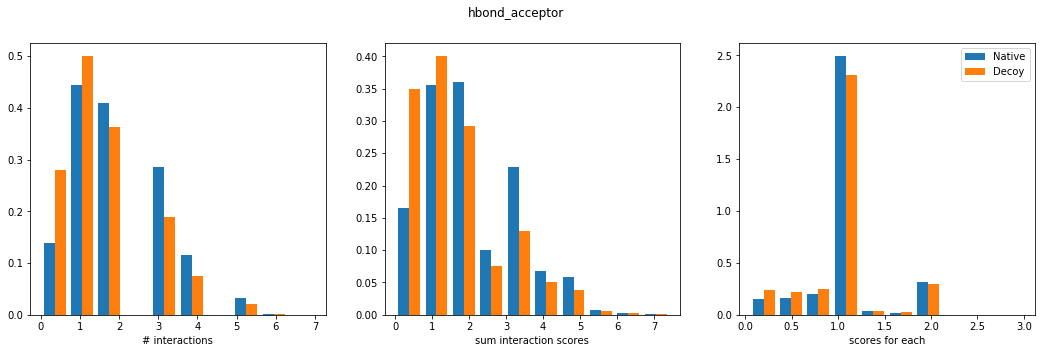

0.648947134273
0.618861626524


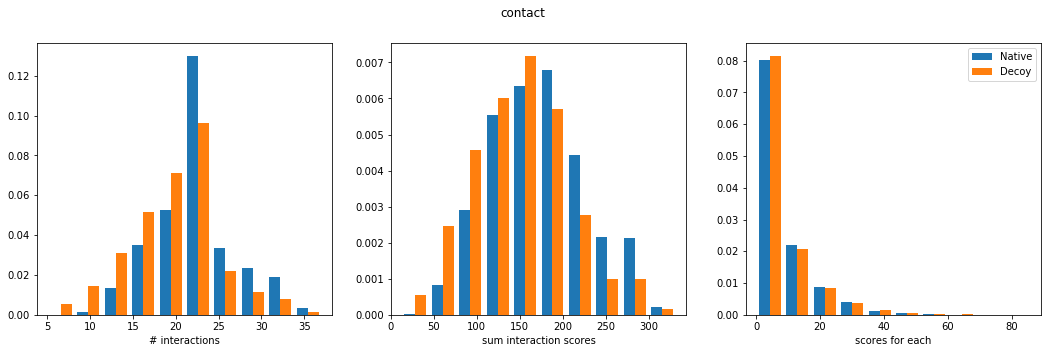

0.661512524353
0.675145357182


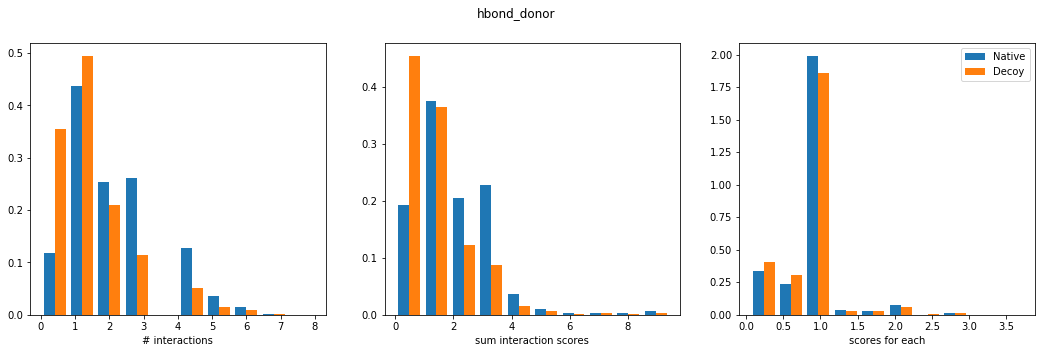

0.479743397305
0.483277877577


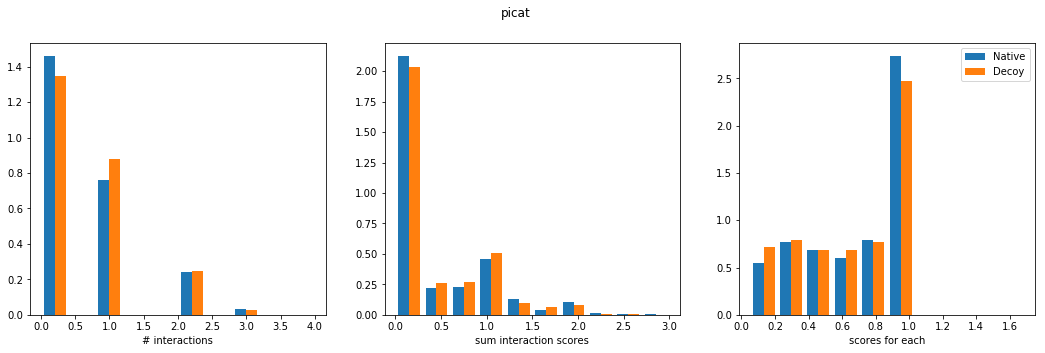

0.455616959646
0.443934774509


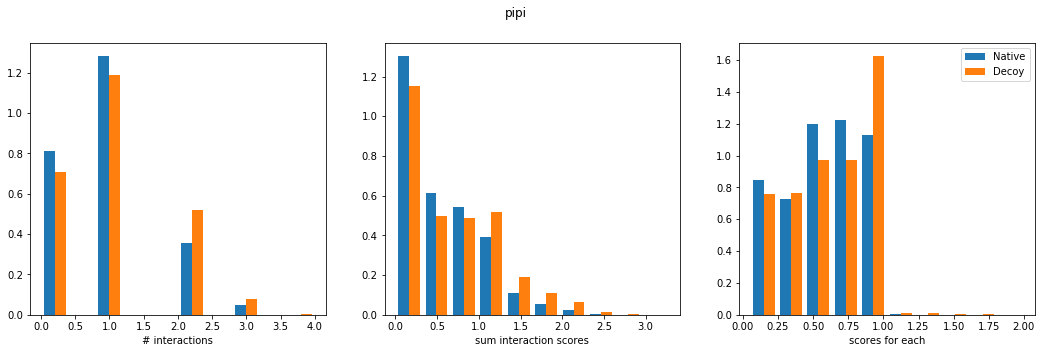

In [54]:
from sklearn.metrics import roc_auc_score

def get_roc(positive, negative, weights = None):
    y = np.hstack([np.ones((len(positive),)),
                   np.zeros((len(negative,)))])
    h = np.hstack([np.array(positive),
                   np.array(negative)])
    return roc_auc_score(y, h, sample_weight = weights)

for feature, codes in features.items():
    scoress_native, scoress_decoy = [], []
    f, ax = plt.subplots(1, 3, figsize = (18, 5))
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            if min(pose[2] for pose in poses.values()) > 2: continue
            for rank, pose in poses.items():
                if pose[2] <= 2:
                    scoress_native += [[score
                                        for (code, residue), score in pose[-1].items()
                                        if code in codes]]
                scoress_decoy  += [[score
                                    for (code, residue), score in pose[-1].items()
                                    if code in codes]]
    ax[0].hist([[len(scores) for scores in scoress_native],
                [len(scores) for scores in scoress_decoy]],
               normed = True)
    print get_roc([len(scores) for scores in scoress_native], [len(scores) for scores in scoress_decoy])
    ax[1].hist([[sum(scores) for scores in scoress_native],
                [sum(scores) for scores in scoress_decoy]],
               normed = True)
    print get_roc([sum(scores) for scores in scoress_native], [sum(scores) for scores in scoress_decoy])
    ax[2].hist([[score for scores in scoress_native for score in scores],
                [score for scores in scoress_decoy for score in scores]],
                label = ['Native', 'Decoy'],
               normed = True)
    ax[0].set_xlabel('# interactions')
    ax[1].set_xlabel('sum interaction scores')
    ax[2].set_xlabel('scores for each')
    ax[2].legend()
    plt.suptitle(feature)
    plt.show()

(47326, 2) (47326,)
Both
0.883398901252
[[ 0.         -0.47477559]]
Only feature
0.5
[[ 0.]]
Only GScore
0.883398901252
[[-0.4747805]]


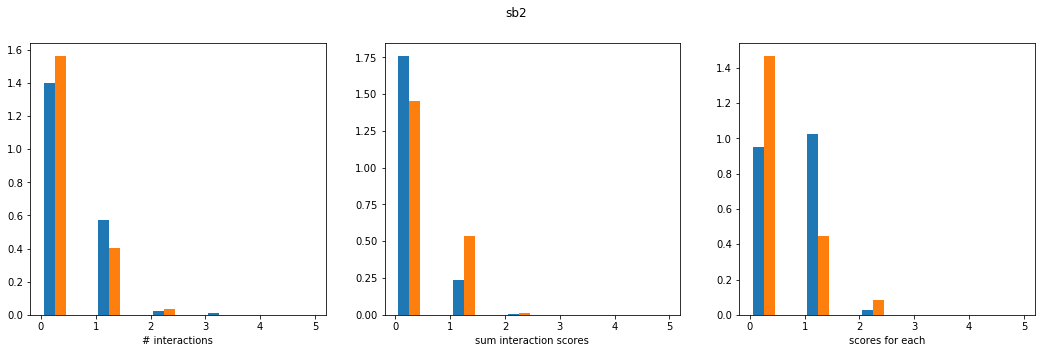

(47326, 2) (47326,)
Both
0.885461226841
[[ 0.04045954 -0.4697035 ]]
Only feature
0.639844573335
[[ 0.21230749]]
Only GScore
0.883398901252
[[-0.47478773]]


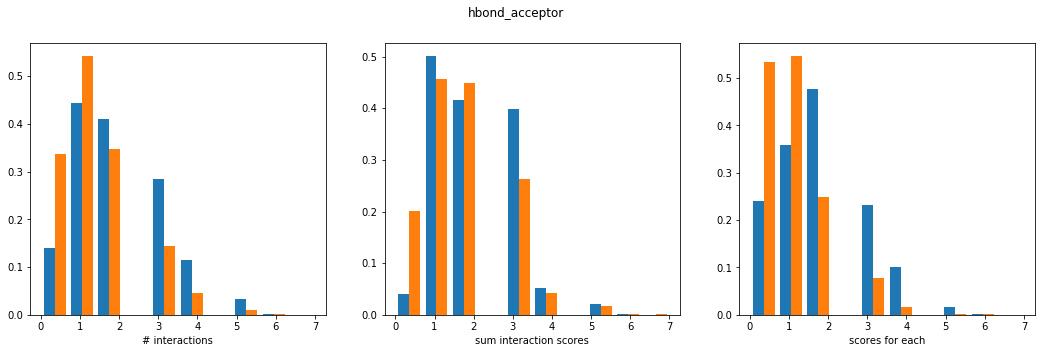

(47326, 2) (47326,)
Both
0.875359588579
[[-0.08764491 -0.60929897]]
Only feature
0.698585853931
[[ 0.0448582]]
Only GScore
0.883398901252
[[-0.47479089]]


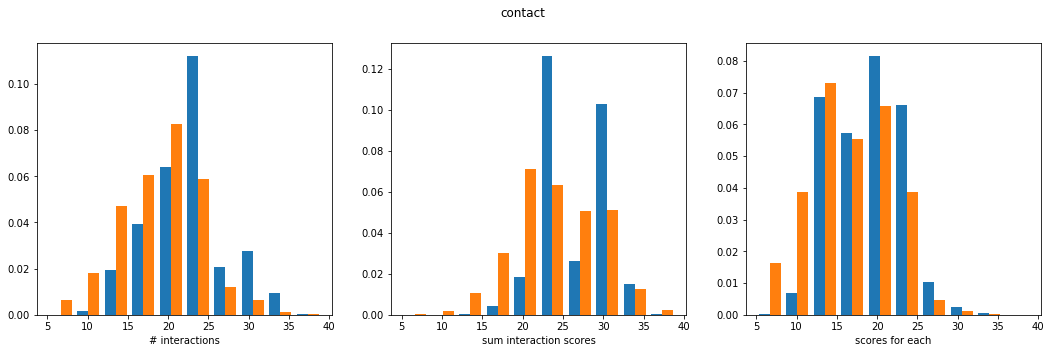

(47326, 2) (47326,)
Both
0.89227082218
[[ 0.23505545 -0.43576021]]
Only feature
0.719838631989
[[ 0.38725173]]
Only GScore
0.883398901252
[[-0.47479312]]


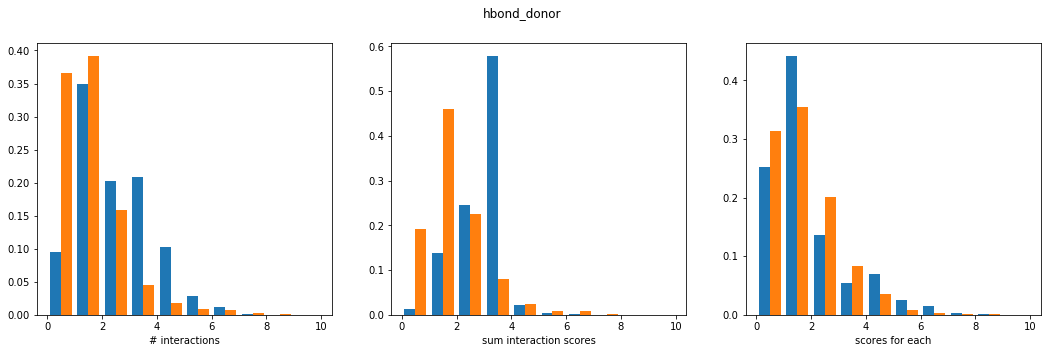

(47326, 2) (47326,)
Both
0.883572384958
[[-0.0211     -0.47419784]]
Only feature
0.547570965077
[[-0.14028939]]
Only GScore
0.883398901252
[[-0.4747959]]


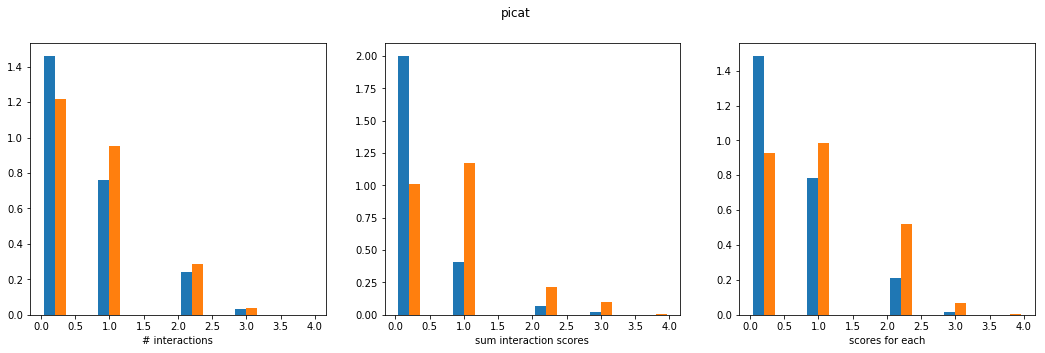

(47326, 2) (47326,)
Both
0.888470150976
[[-0.39589834 -0.48584714]]
Only feature
0.568390397411
[[-0.32068676]]
Only GScore
0.883398901252
[[-0.47487677]]


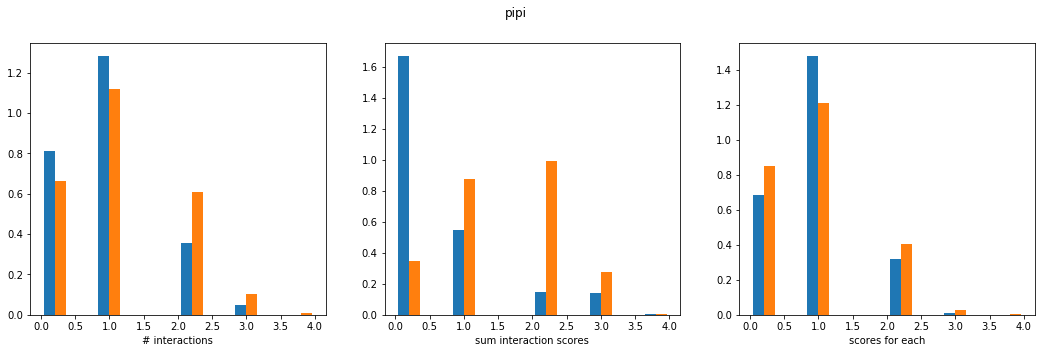

In [160]:
from sklearn.linear_model import LogisticRegression

def model(positive, negative, weights_positive, weights_negative):
    positive, negative = np.array(positive), np.array(negative)
    weights_positive, weights_negative  = np.array(weights_positive), np.array(weights_negative)

    y = np.hstack([np.ones((len(positive),)),
                   np.zeros((len(negative,)))])
    X = np.vstack([np.hstack([positive.reshape(-1, 1), weights_positive.reshape(-1, 1)]),
                   np.hstack([negative.reshape(-1, 1), weights_negative.reshape(-1, 1)])])
    
    print X.shape, y.shape
    
    print 'Both'
    lm = LogisticRegression(penalty = 'l1', C=.001).fit(X, y)
    h = lm.predict_proba(X)[:, 1]
    print roc_auc_score(y, h)
    print lm.coef_
    
    print 'Only feature'
    lm = LogisticRegression(penalty = 'l1', C=.001).fit(X[:, :1], y)
    h = lm.predict_proba(X[:, :1])[:, 1]
    print roc_auc_score(y, h)
    print lm.coef_
    
    print 'Only GScore'
    lm = LogisticRegression(penalty = 'l1', C=.001).fit(X[:, 1:], y)
    h = lm.predict_proba(X[:, 1:])[:, 1]
    print roc_auc_score(y, h)
    print lm.coef_

for feature, codes in features.items():
    scoress_native, scoress_decoy = [], []
    weightss_native, weightss_decoy = [], []
    f, ax = plt.subplots(1, 3, figsize = (18, 5))
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                if pose[2] <= 2:
                    scoress_native += [[score
                                        for (code, residue), score in pose[-1].items()
                                        if code in codes]]
                    weightss_native += [pose[0]]
                else:
                    scoress_decoy  += [[score
                                    for (code, residue), score in pose[-1].items()
                                    if code in codes]]
                    weightss_decoy += [pose[0]]
    ax[0].hist([[len(scores) for scores in scoress_native],
                [len(scores) for scores in scoress_decoy]],
               normed = True)
    ax[1].hist([[len(scores) for scores in scoress_native],
                [len(scores) for scores in scoress_decoy]],
               weights = [[np.exp(-weights) for weights in weightss_native],
                          [np.exp(-weights) for weights in weightss_decoy]],
               normed = True)
    
    ax[2].hist([[len(scores) for scores in scoress_native],
                [len(scores) for scores in scoress_decoy]],
               weights = [[np.exp(weights) for weights in weightss_native],
                          [np.exp(weights) for weights in weightss_decoy]],
               normed = True)
    model([len(scores) for scores in scoress_native],
          [len(scores) for scores in scoress_decoy],
          [weights for weights in weightss_native],
          [weights for weights in weightss_decoy]
         )
#     ax[1].boxplot([len(scores) for scores in scoress_native],
#                   [weights for weights in weightss_native],
#                    )

    ax[0].set_xlabel('# interactions')
    ax[1].set_xlabel('sum interaction scores')
    ax[2].set_xlabel('scores for each')
    ax[2].legend()
    plt.suptitle(feature)
    plt.show()

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log


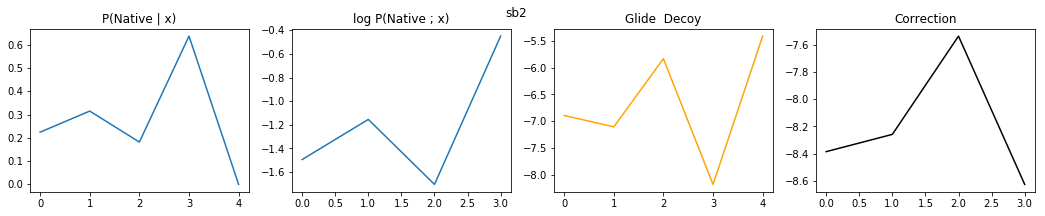

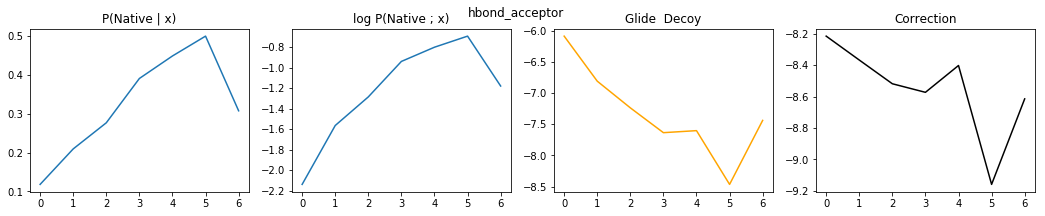

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in subtract
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in subtract


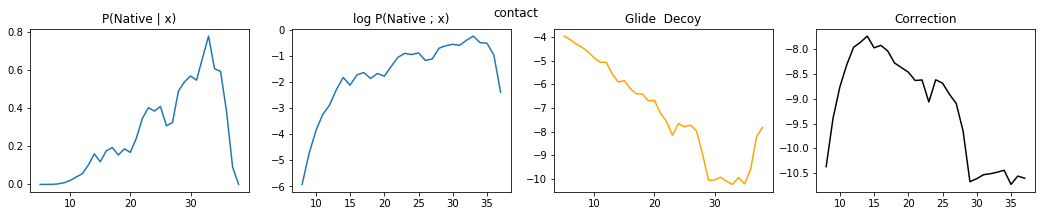

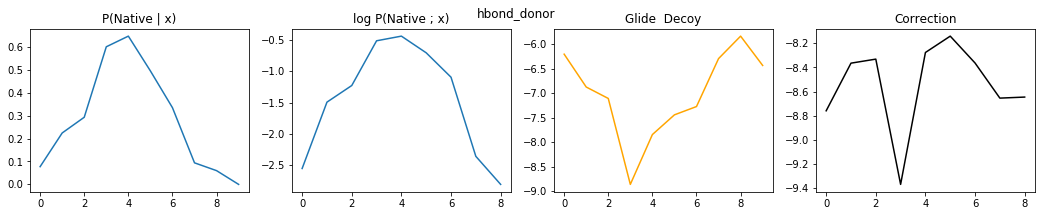

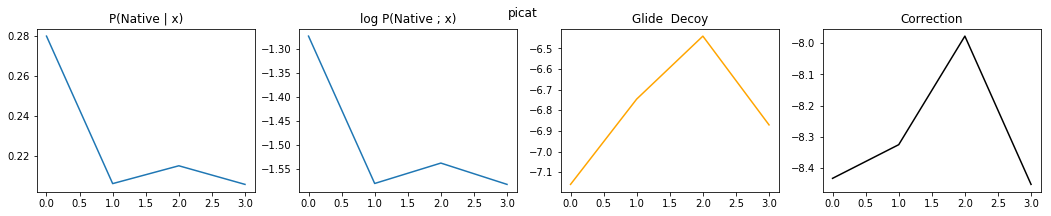

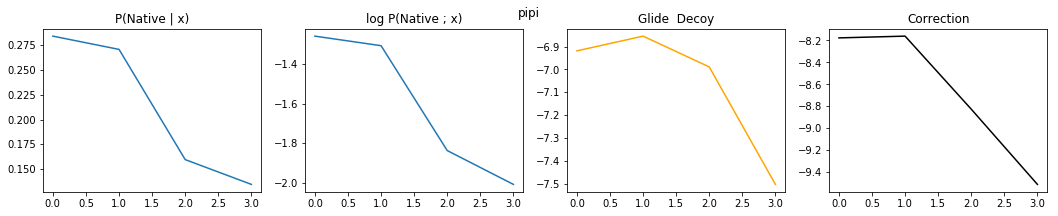

In [218]:
for feature, codes in features.items():
    scoress_native, scoress_decoy = [], []
    w_decoy = []
    f, ax = plt.subplots(1, 4, figsize = (18, 3))
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                if pose[2] <= 2:
                    scoress_native += [[score
                                        for (code, residue), score in pose[-1].items()
                                        if code in codes]]
                scoress_decoy  += [[score
                                    for (code, residue), score in pose[-1].items()
                                    if code in codes]]
                w_decoy += [pose[0]]
    
    x_native = [len(scores) for scores in scoress_native]
    x_decoy  = [len(scores) for scores in scoress_decoy]
    
    # Compute counts
    w_decoy_x = []
    f_native_x, f_decoy_x = [], []
    for i in range(max(x_native+x_decoy)):
        w_native_x += [[]]
        w_decoy_x += [[]]
        f_native_x += [0]
        f_decoy_x += [0]
        for x, w in zip(x_native, w_native):
            if x == i:
                w_native_x[-1] += [w]
                f_native_x[-1] += 1  
        for x, w in zip(x_decoy, w_decoy):
            if x == i:
                w_decoy_x[-1] += [w]
                f_decoy_x[-1] += 1
    f_native_x = np.array(f_native_x)
    f_decoy_x = np.array(f_decoy_x).astype(float)
    
    # Set to mean
    w_decoy_x = np.array([np.mean(w) for w in w_decoy_x])
    
    ax[0].set_title('P(Native | x)')
    ax[0].plot(f_native_x / f_decoy_x)
    
    ax[1].set_title('log P(Native ; x)')
    ax[1].plot(np.log(f_native_x) - np.log(f_decoy_x))

    ax[2].set_title('Glide  Decoy')
    ax[2].plot(w_decoy_x, color = 'orange')
    
    ax[3].set_title('Correction')
    R = np.log(f_native_x) - np.log(f_decoy_x) + w_decoy_x
    ax[3].plot(R, 'k')
    
    plt.suptitle(feature)
    plt.show()

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log


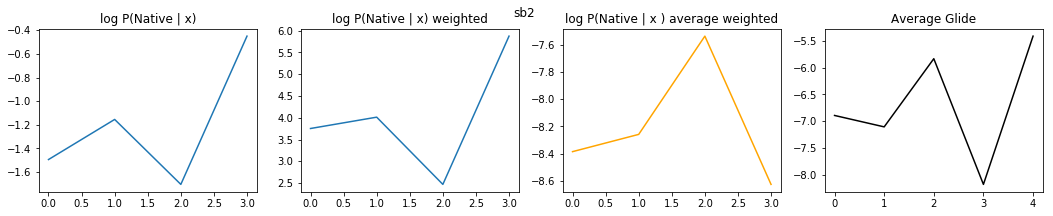

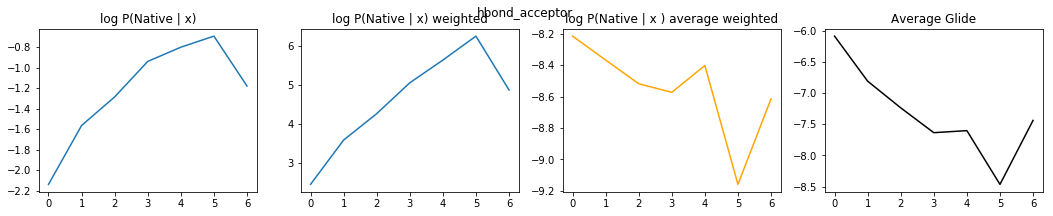

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in subtract
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in subtract
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in subtract


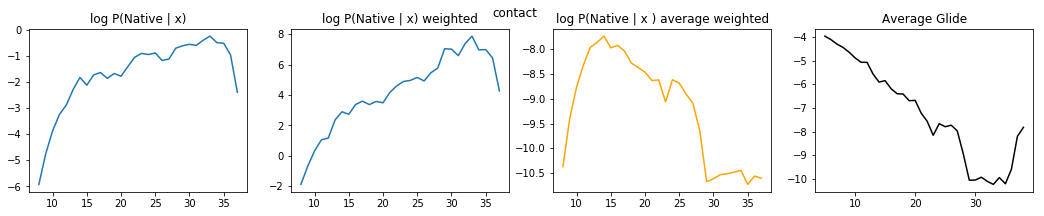

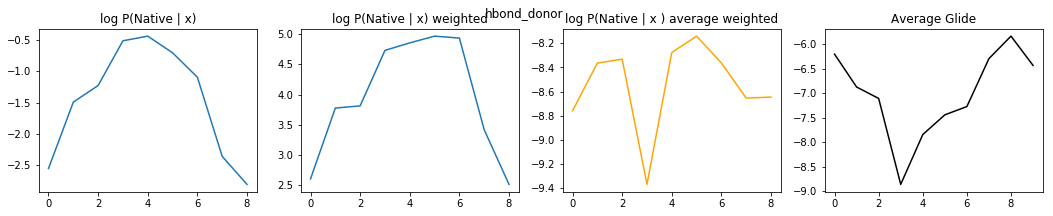

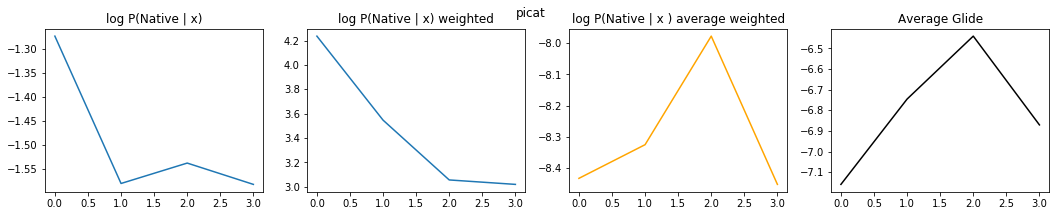

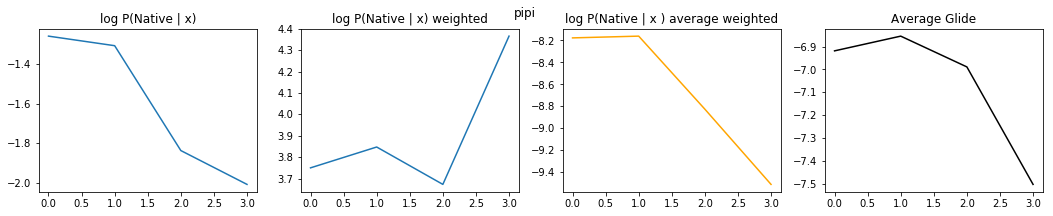

In [235]:
for feature, codes in features.items():
    scoress_native, scoress_decoy = [], []
    w_decoy = []
    f, ax = plt.subplots(1, 4, figsize = (18, 3))
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                if pose[2] <= 2:
                    scoress_native += [[score
                                        for (code, residue), score in pose[-1].items()
                                        if code in codes]]
                scoress_decoy  += [[score
                                    for (code, residue), score in pose[-1].items()
                                    if code in codes]]
                w_decoy += [pose[0]]
    
    x_native = [len(scores) for scores in scoress_native]
    x_decoy  = [len(scores) for scores in scoress_decoy]
    
    
    
    # Compute counts
    f_native_x, f_decoy_x, f_decoy_x_weighted = [], [], []
    w_decoy_x = []
    for i in range(max(x_native+x_decoy)):
        f_native_x += [0]
        f_decoy_x += [0]
        f_decoy_x_weighted += [0]
        w_decoy_x += [[]]
        for x, w in zip(x_native, w_native):
            if x == i:
                f_native_x[-1] += 1
        for x, w in zip(x_decoy, w_decoy):
            if x == i:
                f_decoy_x[-1] += 1
                w_decoy_x[-1] += [w]
                f_decoy_x_weighted[-1] += np.exp(w)
                
    
    f_native_x = np.array(f_native_x)# / float(np.sum(f_native_x))
    f_decoy_x = np.array(f_decoy_x)# / float(np.sum(f_decoy_x))
    f_decoy_x_weighted = np.array(f_decoy_x_weighted).astype(float)
    
    w_decoy_x = np.array([np.mean(w) for w in w_decoy_x])
    
    ax[0].set_title('log P(Native | x)')
    ax[0].plot(np.log(f_native_x) - np.log(f_decoy_x))
    
    ax[1].set_title('log P(Native | x) weighted')
    ax[1].plot(np.log(f_native_x) - np.log(f_decoy_x_weighted))

    ax[2].set_title('log P(Native | x ) average weighted')
    ax[2].plot(np.log(f_native_x) - np.log(f_decoy_x) + w_decoy_x, color = 'orange')
    
    ax[3].set_title('Average Glide')
    ax[3].plot(w_decoy_x, 'k')
    
    plt.suptitle(feature)
    plt.show()

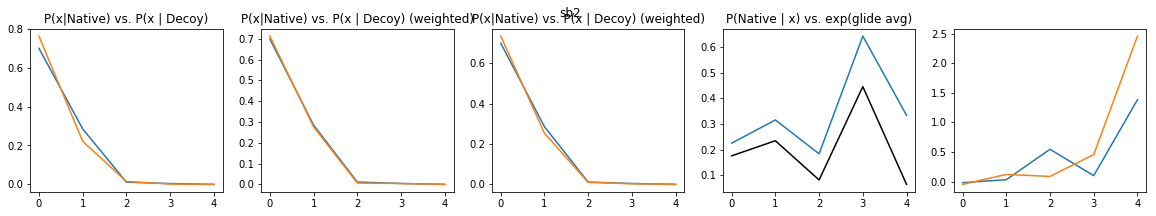

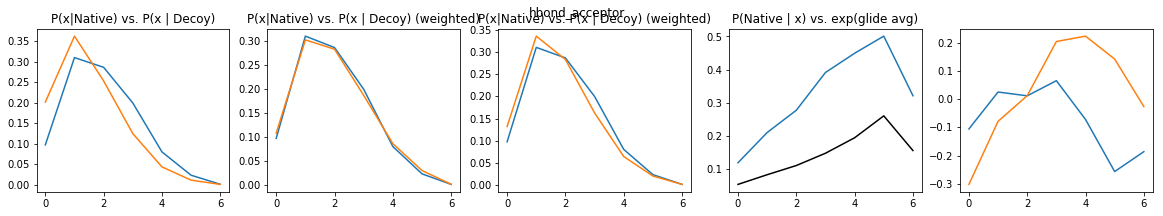

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in log


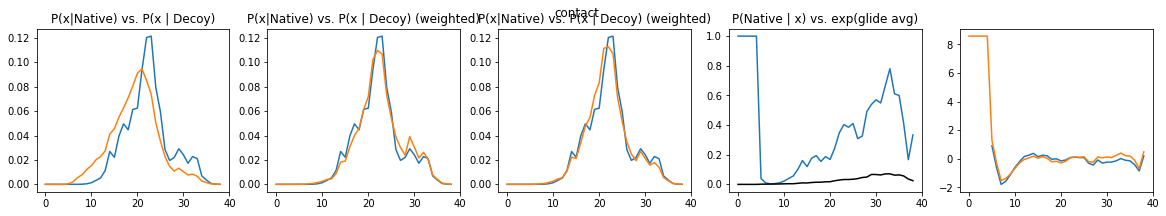

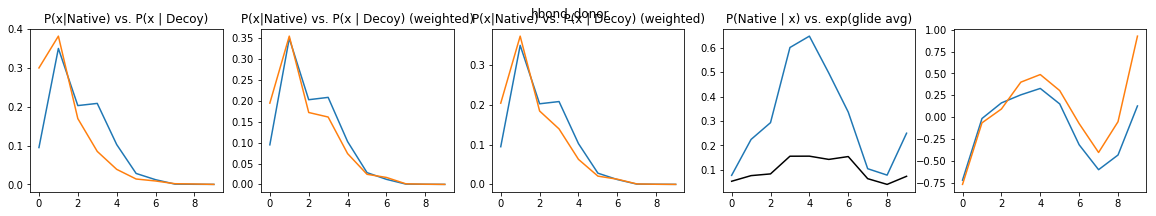

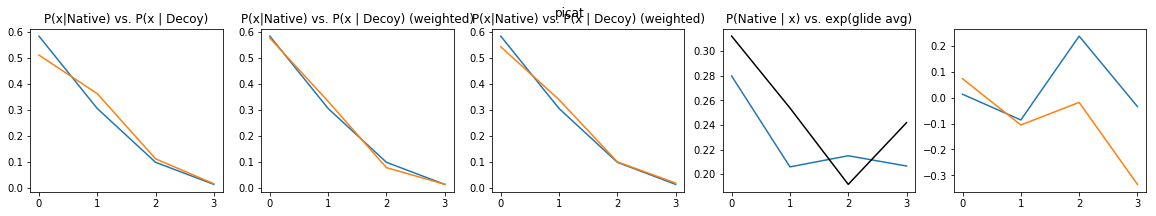

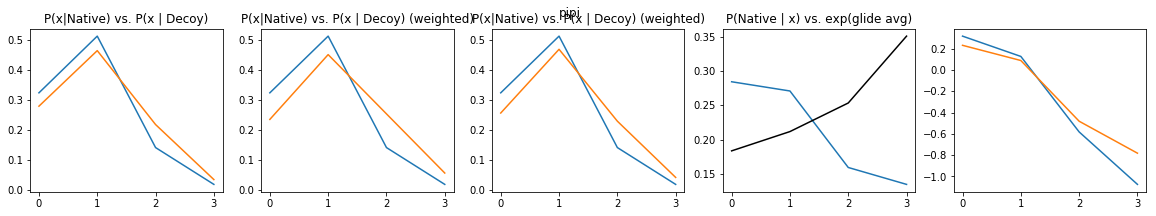

In [331]:
for feature, codes in features.items():
    scoress_native, scoress_decoy = [], []
    w_decoy = []
    f, ax = plt.subplots(1, 5, figsize = (20, 3))
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                if pose[2] <= 2:
                    scoress_native += [[score
                                        for (code, residue), score in pose[-1].items()
                                        if code in codes]]
                scoress_decoy  += [[score
                                    for (code, residue), score in pose[-1].items()
                                    if code in codes]]
                w_decoy += [pose[0]]
    
    x_native = [len(scores) for scores in scoress_native]
    x_decoy  = [len(scores) for scores in scoress_decoy]
    
    
    # Compute counts
    f_native_x, f_decoy_x, f_decoy_x_weighted = [], [], []
    w_decoy_x = []
    for i in range(max(x_native+x_decoy)):
        f_native_x += [1]
        f_decoy_x += [1]
        f_decoy_x_weighted += [1]
        w_decoy_x += [[]]
        for x, w in zip(x_native, w_native):
            if x == i:
                f_native_x[-1] += 1
        for x, w in zip(x_decoy, w_decoy):
            if x == i:
                f_decoy_x[-1] += 1
                f_decoy_x_weighted[-1] += np.exp(-max(w,-8))
                w_decoy_x[-1] += [max(w,-8)]
    
    f_native_x = np.array(f_native_x).astype(float)
    f_decoy_x = np.array(f_decoy_x).astype(float)
    f_decoy_x_weighted = np.array(f_decoy_x_weighted).astype(float)
    
    w_decoy_x = np.array([np.mean(w) if w else 1000 for w in w_decoy_x])
    
    ax[0].set_title('P(x|Native) vs. P(x | Decoy)')
    ax[0].plot(f_native_x / np.sum(f_native_x))
    ax[0].plot(f_decoy_x / np.sum(f_decoy_x))
    
    ax[1].set_title('P(x|Native) vs. P(x | Decoy) (weighted)')
    ax[1].plot(f_native_x / np.sum(f_native_x))
    ax[1].plot((np.exp(-w_decoy_x) * f_decoy_x) / np.sum(np.exp(-w_decoy_x) * f_decoy_x))
    
    ax[2].set_title('P(x|Native) vs. P(x | Decoy) (weighted)')
    ax[2].plot(f_native_x / np.sum(f_native_x))
    ax[2].plot(f_decoy_x_weighted / np.sum(f_decoy_x_weighted))

    
    
    ax[3].set_title('P(Native | x) vs. exp(glide avg)')
    ax[3].plot(f_native_x / f_decoy_x)
    ax[3].plot(np.exp(-w_decoy_x) / np.sum(np.exp(-w_decoy_x)), 'k')
       
    R = np.log(f_native_x) - np.log((np.exp(-w_decoy_x) * f_decoy_x))
    R += - np.log(np.sum(f_native_x)) + np.log(np.sum((np.exp(-w_decoy_x) * f_decoy_x)))
    ax[4].plot(R)
    
    R = np.log(f_native_x) - np.log(f_decoy_x_weighted)
    R += - np.log(np.sum(f_native_x)) + np.log(np.sum(f_decoy_x_weighted))
    ax[4].plot(R)

    
    plt.suptitle(feature)
    plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([-7.5025327 , -7.43772553, -7.37291836, -7.30811119, -7.24330402,
        -7.17849685, -7.11368968, -7.04888251, -6.98407534, -6.91926817,
        -6.854461  ]),
 <a list of 10 Patch objects>)

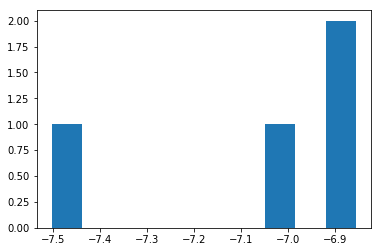

In [216]:
C = []

for feature, codes in features.items():
    scoress_native, scoress_decoy = [], []
    w_native, w_decoy = [], []
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                if pose[2] <= 2:
                    scoress_native += [[score
                                        for (code, residue), score in pose[-1].items()
                                        if code in codes]]
                    w_native += [pose[0]]
                scoress_decoy  += [[score
                                    for (code, residue), score in pose[-1].items()
                                    if code in codes]]
                w_decoy += [pose[0]]
    
    x_native = [len(scores) for scores in scoress_native]
    x_decoy  = [len(scores) for scores in scoress_decoy]
    
    w_native_x, w_decoy_x = [], [] # Glide Scores
    f_native_x, f_decoy_x = [], [] # Counts
    for i in range(max(x_native+x_decoy)):
        w_native_x += [[]]
        w_decoy_x += [[]]
        f_native_x += [0]
        f_decoy_x += [0]
        
        for x, w in zip(x_native, w_native):
            if x == i:
                w_native_x[-1] += [w]
                f_native_x[-1] += 1
            
        for x, w in zip(x_decoy, w_decoy):
            if x == i:
                w_decoy_x[-1] += [w]
                f_decoy_x[-1] += 1

    f_native_x = np.array(f_native_x)
    f_decoy_x = np.array(f_decoy_x).astype(float)
    w_decoy_x = np.array([np.mean(w) for w in w_decoy_x])

    R = np.log(f_native_x) - np.log(f_decoy_x) + w_decoy_x
   
    C += [np.var(R[~np.isnan(R)])]
    
print C, np.mean(C)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in log
/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in subtract


[nan, 0.077875440237057392, nan, nan, 0.036324942753063305, 0.30821048269425511] nan


# Plot interactions for specific receptor

In [6]:
feature = 'hbond_donor'
protein = 'B2AR'

# Get interacting residues
residues = set()
for ligand, poses in data[protein].items():
    for rank, pose in poses.items():
        residues = residues.union(set([residue
                         for (code, residue), score in pose[-1].items()
                         if code == features[feature][0]]))

residues = list(residues)
ligands = data[protein].keys()

native = np.zeros((len(ligands), len(residues)))
native_rmsds = []
for i, ligand in enumerate(ligands):
    for rank, pose in data[protein][ligand].items():
        if pose[2] < 2:
            native_rmsds += [pose[2]]
            for j, residue in enumerate(residues):
                native[i, j] = (pose[-1][(features[feature][0], residue)]
                                if (features[feature][0], residue) in pose[-1]
                                else 0)
            break
    if len(native_rmsds) <= i:
        native_rmsds += [10]

glide = np.zeros((len(ligands), len(residues)))
rmsds = []
for i, ligand in enumerate(ligands):
    pose = data[protein][ligand][0]
    rmsds += [pose[2]]
    for j, residue in enumerate(residues):
        glide[i, j] = (pose[-1][(features[feature][0], residue)]
                       if (features[feature][0], residue) in pose[-1]
                       else 0)

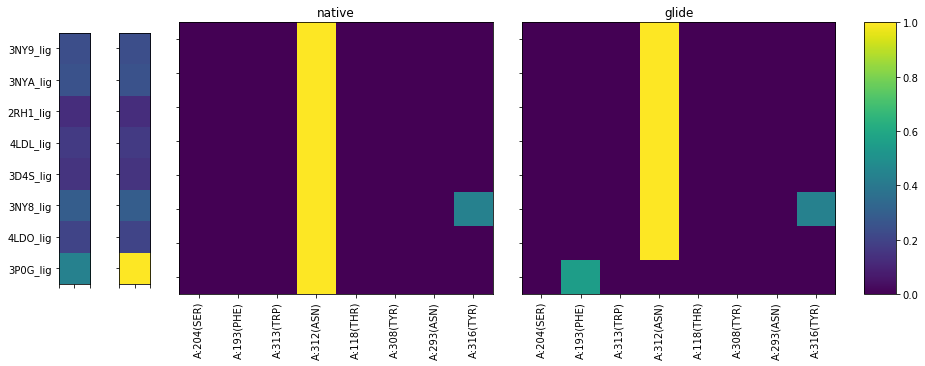

hbond_donor 2


In [7]:
import matplotlib.gridspec as gridspec
f = plt.figure(figsize = (15, 5))

gs = gridspec.GridSpec(1, 5,
                       width_ratios=[1, 1, 10, 10, 1])


plt.subplot(gs[0]).imshow(np.array(native_rmsds).reshape(-1, 1), vmin=0, vmax = 4)
plt.subplot(gs[1]).imshow(np.array(rmsds).reshape(-1, 1), vmin=0, vmax = 4)

plt.subplot(gs[2]).imshow(native, aspect = 'auto', vmin = 0,  vmax = max(np.max(glide), np.max(native)))
sc = plt.subplot(gs[3]).imshow(glide, aspect = 'auto', vmin = 0, vmax = max(np.max(glide), np.max(native)))

plt.subplot(gs[2]).set_title('native')
plt.subplot(gs[3]).set_title('glide')
plt.colorbar(sc, cax = plt.subplot(gs[4]))

plt.subplot(gs[0]).set_yticks(range(len(ligands)))
plt.subplot(gs[0]).set_yticklabels(ligands)
for i in range(1, 4):
    plt.subplot(gs[i]).set_yticklabels([])

for i in [0, 1]:
    plt.subplot(gs[i]).set_xticklabels([])
for i in [2, 3]:
    plt.subplot(gs[i]).set_xticks(range(len(residues)))
    plt.subplot(gs[i]).set_xticklabels(residues, rotation = 'vertical')
plt.show()
print feature, features[feature][0]

# Determine best similarity metric

In [8]:
# form 1: additive residue-level score that is then normalized

# option 1: geometric mean


# Any correlation with correctness?

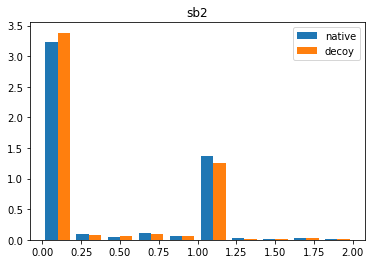

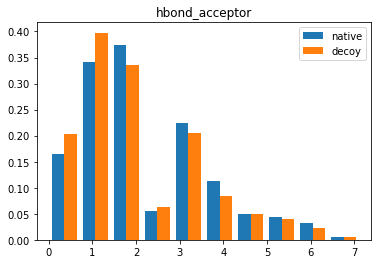

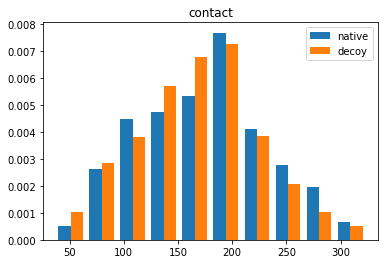

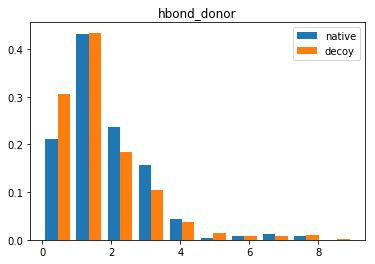

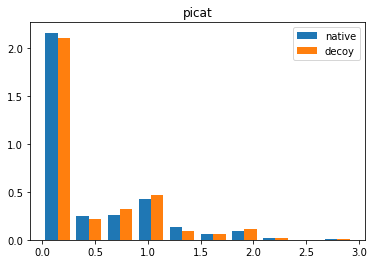

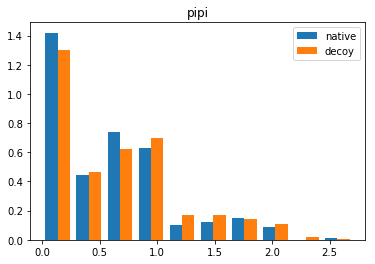

In [12]:
from sklearn.metrics import roc_auc_score

for feature, codes in features.items():
    native, decoy = [], []
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            for rank, pose in poses.items():
                if rank > 1: continue
                count = sum([score for (code, residue), score in pose[-1].items() if code in codes])
                if pose[2] < 2:
                    native += [count]
                decoy += [count]
    plt.hist([native, decoy], label = ['native', 'decoy'], normed = True)
    plt.title(feature)
    plt.legend()
    plt.show()

sb2
0.5 0.575432329772


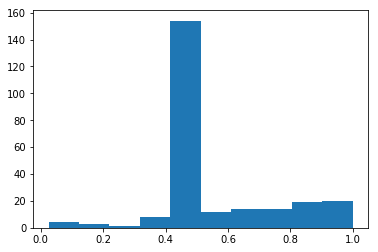

hbond_acceptor
0.55 0.564195901376


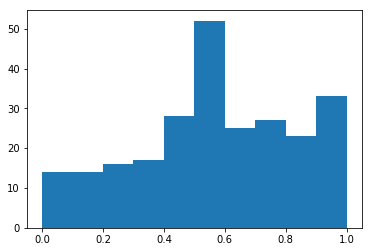

contact
0.65 0.609781046989


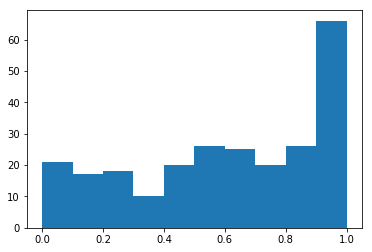

hbond_donor
0.558823529412 0.607359469994


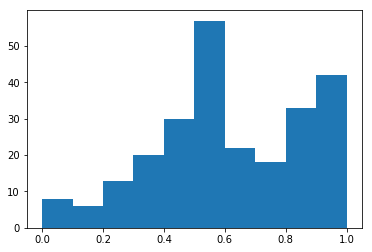

picat
0.5 0.464714841868


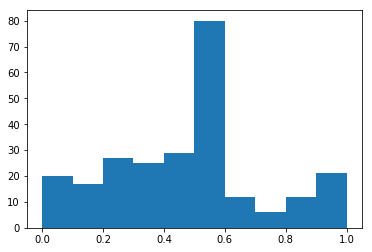

pipi
0.5 0.520557245573


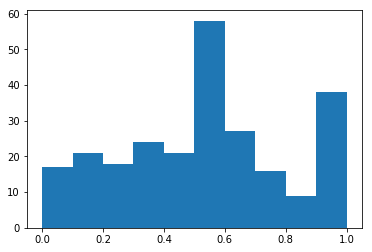

In [10]:
from sklearn.metrics import roc_auc_score

for feature, codes in features.items():
    auc = []
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():
            y = []
            y_hat = []
            weights = []
            for rank, pose in poses.items():
                if rank > 20: continue
                y += [pose[2] < 2]
                y_hat += [sum([score for (code, residue), score in pose[-1].items() if code in codes])]

                #weights += [np.exp(-pose[0])]
            if sum(label == 1 for label in y) and sum(label == 0 for label in y):
                auc += [roc_auc_score(y, y_hat)]
    print feature
    print np.median(auc), np.mean(auc)
    plt.hist(auc)
    plt.show()

In [11]:
from sklearn.metrics import roc_auc_score

for feature, codes in features.items():
    y = []
    y_hat = []
    weights = []
    for protein, ligands in data.items():
        for ligand, poses in ligands.items():

            for rank, pose in poses.items():
                if rank > 1: continue
                y += [pose[2] < 2]
                y_hat += [sum([score for (code, residue), score in pose[-1].items() if code in codes])]
    print feature
    print roc_auc_score(y, y_hat)

sb2
0.532095344977
hbond_acceptor
0.571247652225
contact
0.571504835831
hbond_donor
0.610343457015
picat
0.474587532051
pipi
0.437217974796
